In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import PIL.Image
from pathlib import Path
import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
import time
import timm

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
nfolds = 4
fname = 'resnet50'
IMAGE_DIR = '/kaggle/input/panda-16x128x128-tiles-data/train'
LABELS = '/kaggle/input/prostate-cancer-grade-assessment/train.csv'
SEED = 2024

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
loss_name = "mse"
TRAIN_DATASET_FRAC = 1
num_epochs = 20
EARLY_STOPPING = True
MIN_EPOCH = 10
PATIENCE = 8

## Seed everything

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Dataset class

In [5]:
class ProstateTilesDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, n_tiles=(3, 4), transform=None):
        self.df = df
        self.image_dir = image_dir
        self.n_tiles = n_tiles  
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row.image_id
        label = row.isup_grade
        tile_rows, tile_cols = self.n_tiles
        imgs = []
        for i in range(tile_rows):
            for j in range(tile_cols):
                img_path = Path(self.image_dir, f'{img_id}_{i * tile_cols + j}.png')
                img = PIL.Image.open(img_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
        imgs = torch.stack(imgs) # (12, 3, 128, 128)
        return imgs, label

## Model

In [6]:
class CustomPool(nn.Module):
    def __init__(self, N=12):
        super(CustomPool, self).__init__()
        self.avg_pool = nn.AvgPool1d(kernel_size=N)
        self.max_pool = nn.MaxPool1d(kernel_size=N)

    def forward(self, x):
        # x = (BS, 12, 2048)
        x = x.transpose(1, 2)  # (BS, 512, 12)
        avg_pooled = self.avg_pool(x).squeeze(-1)  # (BS, 512)
        max_pooled = self.max_pool(x).squeeze(-1)  # (BS, 512)
        concatenated_features = torch.cat((avg_pooled, max_pooled), dim=1)  # (BS, 512*2)
        return concatenated_features

In [7]:
class Model(nn.Module):
    def __init__(self, num_classes=1): # change back to 6
        super().__init__()
        self.enc = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=0)
        
        
        nc = self.enc.feature_info[-1]['num_chs']
        self.pool = CustomPool()
        self.head = nn.Sequential(
            nn.Linear(nc*2,512), # (BS, 12, 512)
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.25),
            nn.Linear(512,num_classes)
        )
        
    def forward(self, x):
        # x = (BS, 12, 3, 128, 128)
        n = x.shape[1]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # (BS*12, 3, 128, 128)
        x = self.enc(x) # (BS*12, nc)
        x = x.view(-1,n,x.shape[1]) # (BS, 12, nc)
        x = self.pool(x) # (BS, 512*2)
        x = self.head(x)
        return x

## Training utility functions

In [8]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Train"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(inputs)
            if loss_name == "mse":
                loss = criterion(outputs.squeeze(-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
    
    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    return average_loss

In [9]:
def go_from_mse_logit_to_prediction(logit):
    if logit < 0.5:
        return 0
    elif logit < 1.5:
        return 1
    elif logit < 2.5:
        return 2
    elif logit < 3.5:
        return 3
    elif logit < 4.5:
        return 4
    else:
        return 5

In [10]:
def tune(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Tune"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float()
                outputs = model(inputs)
                if loss_name == "mse":
                    loss = criterion(outputs.squeeze(-1), labels)
                else:
                    loss = criterion(outputs, labels)
                total_loss += loss.item()
                if loss_name == "mse":
                    preds = [go_from_mse_logit_to_prediction(o) for o in outputs]
                else:
                    preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(dataloader)
    end_time = time.time()  
    elapsed_time = end_time - start_time 
    kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return average_loss, kappa, all_preds, all_labels

In [11]:
def log_metrics(epoch, fold, train_loss, tune_loss, kappa):
    logs = {'epoch': epoch, 'fold': fold, 'train_loss': train_loss, 'tune_loss': tune_loss, 'kappa': kappa}
    logs_folder = Path("/kaggle/working/logs")
    logs_folder.mkdir(exist_ok=True)
    log_file = Path(logs_folder, f'log_{fname}_{fold}.json')
    if log_file.is_file():
        with open(log_file, 'r') as file:
            data = json.load(file)
    else:
        data = []
    data.append(logs)
    with open(log_file, 'w') as file:
        json.dump(data, file)

In [12]:
def save_best_model(model, best_val, current_val, fold, epoch, min_max="min"):
    improve_flag = False
    if min_max == "max":
        best_val = -1 * best_val
        current_val = -1 * current_val
    if current_val < best_val:
        improve_flag = True
        best_val = current_val
        torch.save(model.state_dict(), f'{fname}_{fold}.pth')
        print(f"Saved better model for fold {fold} at epoch {epoch}")
    if min_max == "max":
        best_val = -1 * best_val
    return best_val, improve_flag

## Model training

In [13]:
df = pd.read_csv(LABELS)
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [14]:
# grab slide ids in /kaggle/input/panda-16x128x128-tiles-data
slide_ids = list(set([fp.stem.split("_")[0] for fp in Path(IMAGE_DIR).glob("*.png")]))
len(slide_ids)

10516

In [15]:
# restrict previous dataframe to those ids
df_restricted = df[df.image_id.isin(slide_ids)].reset_index(drop=True)
len(df) - len(df_restricted)

100

In [16]:
skf = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
X = df_restricted.image_id.values
y = df_restricted.isup_grade.values
train_dfs, tune_dfs = [], []
for i, (train_index, tune_index) in enumerate(skf.split(X, y)):
    train_df, tune_df = df_restricted.loc[train_index], df_restricted.loc[tune_index]
    if TRAIN_DATASET_FRAC < 1.0:
        train_df = train_df.sample(frac=TRAIN_DATASET_FRAC, random_state=SEED)
    train_df = train_df.reset_index(drop=True)
    tune_df = tune_df.reset_index(drop=True)
    train_dfs.append(train_df)
    tune_dfs.append(tune_df)
    print(f"fold {i+1}/{nfolds}: train={len(train_df)}, tune={len(tune_df)}")

fold 1/4: train=7887, tune=2629
fold 2/4: train=7887, tune=2629
fold 3/4: train=7887, tune=2629
fold 4/4: train=7887, tune=2629


In [17]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])

In [18]:
def show_image(img_tensor, title):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [20]:
all_folds_preds = []
all_folds_labels = []
for fold in range(nfolds):

    train_dataset = ProstateTilesDataset(train_dfs[fold], IMAGE_DIR, transform=transform)
    tune_dataset = ProstateTilesDataset(tune_dfs[fold], IMAGE_DIR, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    tune_loader = torch.utils.data.DataLoader(tune_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    if loss_name == "mse":
        num_classes =  1
        criterion = nn.MSELoss()
    else:
        num_classes = 6
        criterion = nn.CrossEntropyLoss()
        
    model = Model(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_kappa = -np.inf
    best_loss = np.inf
    best_fold_dict = {
            "epochs": [None] * num_epochs,
            "kappa": [None] * num_epochs,
            "preds": [None] * num_epochs,
            "labels": [None] * num_epochs,
            "loss": [float('inf')] * num_epochs
        }


    
    early_stopping_count = 0
    
    with tqdm(
        range(num_epochs),
        desc=f"Fold {fold+1}/{nfolds}",
        unit=" epoch",
        leave=True,
    ) as t:
        for epoch in t:
            train_loss = train(model, train_loader, criterion, optimizer, device)
            tqdm.write(f"Epoch {epoch} - train_loss: {train_loss:.4f}")
            valid_loss, kappa, fold_preds, fold_labels = tune(model, tune_loader, criterion, device)
            tqdm.write(f"Epoch {epoch} - tune loss: {valid_loss:.4f}")
            tqdm.write(f"Epoch {epoch} - tune kappa: {kappa:.4f}")
            log_metrics(epoch, fold, train_loss, valid_loss, kappa)
        
            best_fold_dict["epochs"][epoch] = (epoch + 1)
            best_fold_dict["kappa"][epoch] = kappa
            best_fold_dict["preds"][epoch] = fold_preds
            best_fold_dict["labels"][epoch] = fold_labels
            best_fold_dict["loss"][epoch] = valid_loss

            
            # best_kappa, improve_flag = save_best_model(model, best_kappa, kappa, fold, epoch, min_max="max")
            best_loss, improve_flag = save_best_model(model, best_loss, valid_loss, fold, epoch,  min_max="min")
            if not improve_flag:
                early_stopping_count += 1
            if EARLY_STOPPING and early_stopping_count > PATIENCE and epoch >= MIN_EPOCH:
                print(f"Epoch {epoch} - Stopping early as model didn't improve over the last {PATIENCE} epochs")
                break
    
    
    # get best epoch based on lowest loss
    min_value_index = best_fold_dict['loss'].index(min(best_fold_dict['loss']))
    best_epoch = best_fold_dict['epochs'][min_value_index]
    loss_best = best_fold_dict['loss'][min_value_index]
    print(f'Best performing epoch of fold {fold +1} is {best_epoch} with a loss of {loss_best}')

    all_folds_preds.extend(best_fold_dict["preds"][min_value_index])
    all_folds_labels.extend(best_fold_dict["labels"][min_value_index])
    

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Fold 1/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 2.0832


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.6252
Epoch 0 - tune kappa: 0.6723
Saved better model for fold 0 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.5050


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.5980
Epoch 1 - tune kappa: 0.6864
Saved better model for fold 0 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.2764


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.4774
Epoch 2 - tune kappa: 0.6436
Saved better model for fold 0 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.1084


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.4535
Epoch 3 - tune kappa: 0.6722
Saved better model for fold 0 at epoch 3


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.9135


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.4838
Epoch 4 - tune kappa: 0.6818


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.7271


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.5907
Epoch 5 - tune kappa: 0.6529


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.6633


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.3507
Epoch 6 - tune kappa: 0.7361
Saved better model for fold 0 at epoch 6


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.5235


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.3427
Epoch 7 - tune kappa: 0.7001
Saved better model for fold 0 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.4849


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.2583
Epoch 8 - tune kappa: 0.7365
Saved better model for fold 0 at epoch 8


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.4137


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.4207
Epoch 9 - tune kappa: 0.7010


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.4268


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.3856
Epoch 10 - tune kappa: 0.6957


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.4137


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.2261
Epoch 11 - tune kappa: 0.7496
Saved better model for fold 0 at epoch 11


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.3942


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.2546
Epoch 12 - tune kappa: 0.7202


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.4097


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.1816
Epoch 13 - tune kappa: 0.7480
Saved better model for fold 0 at epoch 13


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 0.3654


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.1913
Epoch 14 - tune kappa: 0.7631


Epoch 15 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 15 - train_loss: 0.3426


Epoch 15 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 15 - tune loss: 1.3051
Epoch 15 - tune kappa: 0.7362


Epoch 16 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 16 - train_loss: 0.3497


Epoch 16 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 16 - tune loss: 1.2600
Epoch 16 - tune kappa: 0.7150


Epoch 17 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 17 - train_loss: 0.3223


Epoch 17 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 17 - tune loss: 1.3221
Epoch 17 - tune kappa: 0.7339
Epoch 17 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 1 is 14 with a loss of 1.1816240829157543


Fold 2/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 2.1534


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 2.3397
Epoch 0 - tune kappa: 0.4916
Saved better model for fold 1 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.5099


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.4418
Epoch 1 - tune kappa: 0.6698
Saved better model for fold 1 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.3199


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.5577
Epoch 2 - tune kappa: 0.6836


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.1362


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.4809
Epoch 3 - tune kappa: 0.6910


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.9238


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.5375
Epoch 4 - tune kappa: 0.6365


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.8108


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.5796
Epoch 5 - tune kappa: 0.6945


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.6291


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.5357
Epoch 6 - tune kappa: 0.6318


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.5436


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.4336
Epoch 7 - tune kappa: 0.7186
Saved better model for fold 1 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.4726


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.2439
Epoch 8 - tune kappa: 0.7350
Saved better model for fold 1 at epoch 8


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.4244


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.3043
Epoch 9 - tune kappa: 0.7093


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.4389


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.3792
Epoch 10 - tune kappa: 0.6938


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.4122


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.2615
Epoch 11 - tune kappa: 0.7753


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.3814


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.2884
Epoch 12 - tune kappa: 0.7099
Epoch 12 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 2 is 9 with a loss of 1.2439462140382054


Fold 3/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 2.1160


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.5211
Epoch 0 - tune kappa: 0.6755
Saved better model for fold 2 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.4747


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.4019
Epoch 1 - tune kappa: 0.6898
Saved better model for fold 2 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.2753


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.3959
Epoch 2 - tune kappa: 0.7080
Saved better model for fold 2 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.1163


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.5781
Epoch 3 - tune kappa: 0.6851


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.9178


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.5057
Epoch 4 - tune kappa: 0.6386


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.7571


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.3460
Epoch 5 - tune kappa: 0.7173
Saved better model for fold 2 at epoch 5


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.6848


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.5721
Epoch 6 - tune kappa: 0.6885


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.5697


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.3172
Epoch 7 - tune kappa: 0.7485
Saved better model for fold 2 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.5301


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.3220
Epoch 8 - tune kappa: 0.7244


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.4683


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.5992
Epoch 9 - tune kappa: 0.6678


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.4334


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.2386
Epoch 10 - tune kappa: 0.7324
Saved better model for fold 2 at epoch 10


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.3834


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.3292
Epoch 11 - tune kappa: 0.7513


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.3793


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.3102
Epoch 12 - tune kappa: 0.7203


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.3467


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.3390
Epoch 13 - tune kappa: 0.6939


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 0.3573


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.3236
Epoch 14 - tune kappa: 0.7275
Epoch 14 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 3 is 11 with a loss of 1.2385854828788574


Fold 4/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 2.1198


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.7060
Epoch 0 - tune kappa: 0.6658
Saved better model for fold 3 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.5051


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.9135
Epoch 1 - tune kappa: 0.5469


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.3110


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.6133
Epoch 2 - tune kappa: 0.6812
Saved better model for fold 3 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.1499


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.4263
Epoch 3 - tune kappa: 0.7110
Saved better model for fold 3 at epoch 3


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.0017


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.3077
Epoch 4 - tune kappa: 0.7187
Saved better model for fold 3 at epoch 4


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.8863


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.3369
Epoch 5 - tune kappa: 0.6833


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.6951


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.2399
Epoch 6 - tune kappa: 0.7471
Saved better model for fold 3 at epoch 6


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.6076


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.2461
Epoch 7 - tune kappa: 0.7459


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.5468


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.1732
Epoch 8 - tune kappa: 0.7704
Saved better model for fold 3 at epoch 8


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.4772


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.2244
Epoch 9 - tune kappa: 0.7286


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.4254


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.2652
Epoch 10 - tune kappa: 0.7495


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.3813


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.1942
Epoch 11 - tune kappa: 0.7731


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 0.3737


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.2419
Epoch 12 - tune kappa: 0.7480


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 0.3647


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.1467
Epoch 13 - tune kappa: 0.7683
Saved better model for fold 3 at epoch 13


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 0.3654


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.0891
Epoch 14 - tune kappa: 0.7533
Saved better model for fold 3 at epoch 14


Epoch 15 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 15 - train_loss: 0.3265


Epoch 15 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 15 - tune loss: 1.1174
Epoch 15 - tune kappa: 0.7541


Epoch 16 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 16 - train_loss: 0.3245


Epoch 16 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 16 - tune loss: 1.0882
Epoch 16 - tune kappa: 0.7771
Saved better model for fold 3 at epoch 16


Epoch 17 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 17 - train_loss: 0.3105


Epoch 17 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 17 - tune loss: 1.1899
Epoch 17 - tune kappa: 0.7547
Epoch 17 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 4 is 17 with a loss of 1.0882177194019398


Overall CV Score: 0.7485


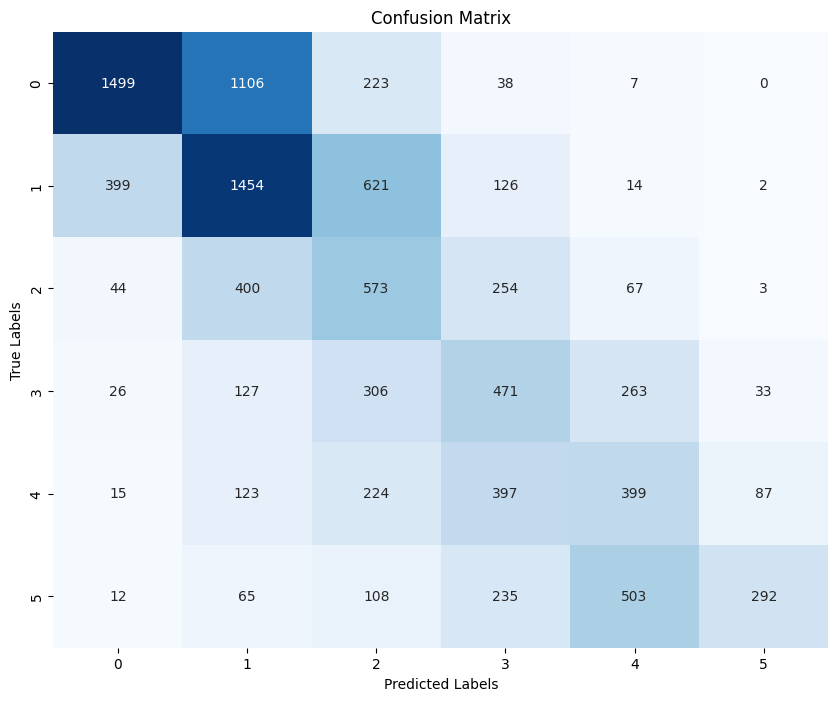

In [21]:
preds_array = np.array(all_folds_preds)
labels_array = np.array(all_folds_labels)

kappa_score = cohen_kappa_score(labels_array, preds_array, weights='quadratic')
print(f"Overall CV Score: {kappa_score:.4f}")

cm = confusion_matrix(labels_array, preds_array)

plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Plot loss curves 

{'epoch': 0, 'fold': 0, 'train_loss': 2.0831721316464997, 'tune_loss': 1.6251540227108692, 'kappa': 0.6722862512529094}
{'epoch': 1, 'fold': 0, 'train_loss': 1.504998799036389, 'tune_loss': 1.5979985551661755, 'kappa': 0.6864055330708538}
{'epoch': 2, 'fold': 0, 'train_loss': 1.276385552125421, 'tune_loss': 1.4773876746016812, 'kappa': 0.6435622662518068}
{'epoch': 3, 'fold': 0, 'train_loss': 1.108360693884282, 'tune_loss': 1.4535330598612866, 'kappa': 0.6721787014686824}
{'epoch': 4, 'fold': 0, 'train_loss': 0.9134830681659915, 'tune_loss': 1.4837726577218757, 'kappa': 0.6818432970580639}
{'epoch': 5, 'fold': 0, 'train_loss': 0.7270880973773447, 'tune_loss': 1.5907160539224923, 'kappa': 0.6529384974868747}
{'epoch': 6, 'fold': 0, 'train_loss': 0.6633070971560382, 'tune_loss': 1.3506562275340759, 'kappa': 0.7361414493189911}
{'epoch': 7, 'fold': 0, 'train_loss': 0.5235442524014214, 'tune_loss': 1.3426601901111832, 'kappa': 0.7001476303222373}
{'epoch': 8, 'fold': 0, 'train_loss': 0.484

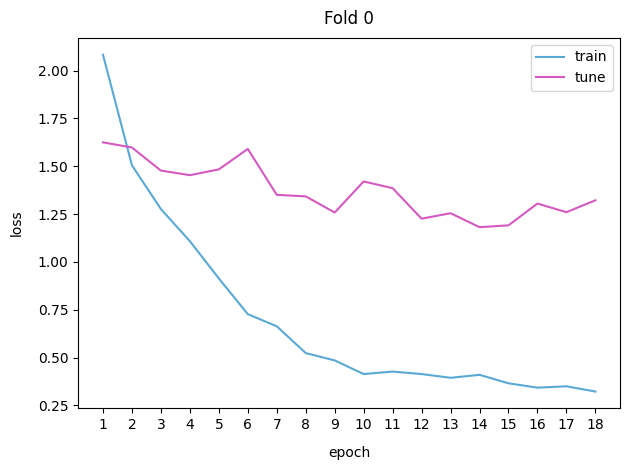

{'epoch': 0, 'fold': 1, 'train_loss': 2.15335518821531, 'tune_loss': 2.339734140648899, 'kappa': 0.4915855147007767}
{'epoch': 1, 'fold': 1, 'train_loss': 1.509894487828861, 'tune_loss': 1.4418452166649232, 'kappa': 0.6698218670298091}
{'epoch': 2, 'fold': 1, 'train_loss': 1.3199162029544351, 'tune_loss': 1.55770931689136, 'kappa': 0.6836479666323174}
{'epoch': 3, 'fold': 1, 'train_loss': 1.1361791707484827, 'tune_loss': 1.4809229402657014, 'kappa': 0.6910394667817835}
{'epoch': 4, 'fold': 1, 'train_loss': 0.9237540576622071, 'tune_loss': 1.537524479699422, 'kappa': 0.6364949905468484}
{'epoch': 5, 'fold': 1, 'train_loss': 0.8108319410910974, 'tune_loss': 1.5796048472444695, 'kappa': 0.6944599164932921}
{'epoch': 6, 'fold': 1, 'train_loss': 0.6291026225698139, 'tune_loss': 1.53565756240523, 'kappa': 0.6317716153070215}
{'epoch': 7, 'fold': 1, 'train_loss': 0.5436224710603474, 'tune_loss': 1.4336175810859864, 'kappa': 0.7186344248493135}
{'epoch': 8, 'fold': 1, 'train_loss': 0.472626703

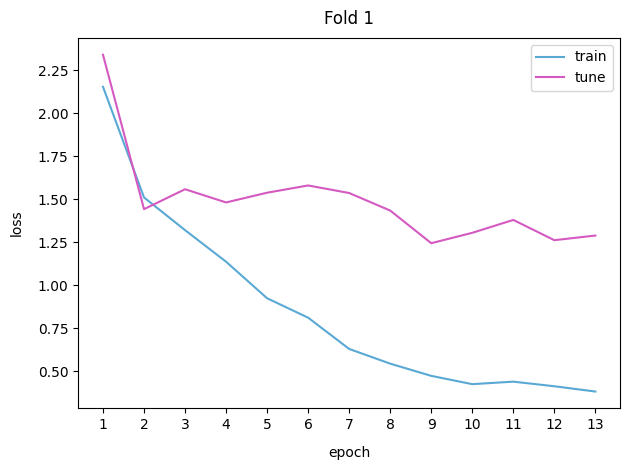

{'epoch': 0, 'fold': 2, 'train_loss': 2.116038624332984, 'tune_loss': 1.5210648487849407, 'kappa': 0.6755499863975427}
{'epoch': 1, 'fold': 2, 'train_loss': 1.4747215622832417, 'tune_loss': 1.4019466279500938, 'kappa': 0.6897888419956334}
{'epoch': 2, 'fold': 2, 'train_loss': 1.275275299906248, 'tune_loss': 1.3958889612232346, 'kappa': 0.7080365701065139}
{'epoch': 3, 'fold': 2, 'train_loss': 1.1163319345669225, 'tune_loss': 1.5780527864594058, 'kappa': 0.6851464725903111}
{'epoch': 4, 'fold': 2, 'train_loss': 0.9177974901701275, 'tune_loss': 1.505681768957391, 'kappa': 0.6385994042209986}
{'epoch': 5, 'fold': 2, 'train_loss': 0.757096725738483, 'tune_loss': 1.3459996430270642, 'kappa': 0.7173355187473452}
{'epoch': 6, 'fold': 2, 'train_loss': 0.6848271887312051, 'tune_loss': 1.5720732887107205, 'kappa': 0.6884692576925697}
{'epoch': 7, 'fold': 2, 'train_loss': 0.5696918591555313, 'tune_loss': 1.3172403645802693, 'kappa': 0.7485395217821333}
{'epoch': 8, 'fold': 2, 'train_loss': 0.5301

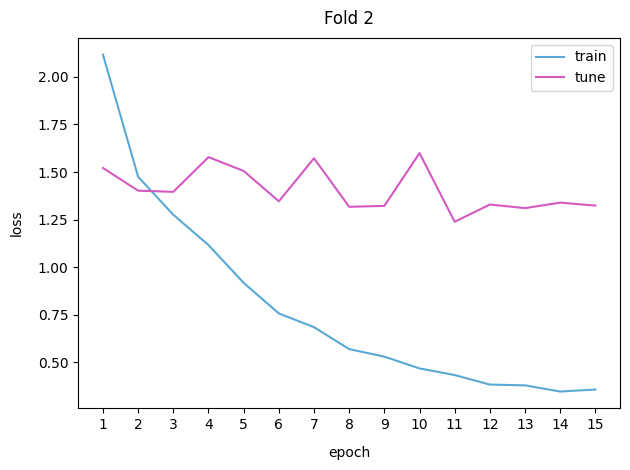

{'epoch': 0, 'fold': 3, 'train_loss': 2.1197800440826877, 'tune_loss': 1.706042826893818, 'kappa': 0.6658072196331433}
{'epoch': 1, 'fold': 3, 'train_loss': 1.5051100058594213, 'tune_loss': 1.9135029473936702, 'kappa': 0.5468845148407409}
{'epoch': 2, 'fold': 3, 'train_loss': 1.3109708930316724, 'tune_loss': 1.613274906773165, 'kappa': 0.6811681823984046}
{'epoch': 3, 'fold': 3, 'train_loss': 1.1498723264165254, 'tune_loss': 1.426307306950351, 'kappa': 0.7109977086987129}
{'epoch': 4, 'fold': 3, 'train_loss': 1.0017400634916205, 'tune_loss': 1.3077055689800217, 'kappa': 0.7187141269476258}
{'epoch': 5, 'fold': 3, 'train_loss': 0.8862749037713658, 'tune_loss': 1.3369441894163567, 'kappa': 0.6833436608297188}
{'epoch': 6, 'fold': 3, 'train_loss': 0.6951422937485853, 'tune_loss': 1.2398657393024628, 'kappa': 0.7470764234619709}
{'epoch': 7, 'fold': 3, 'train_loss': 0.607597358796278, 'tune_loss': 1.246093658079584, 'kappa': 0.7459479943948668}
{'epoch': 8, 'fold': 3, 'train_loss': 0.54681

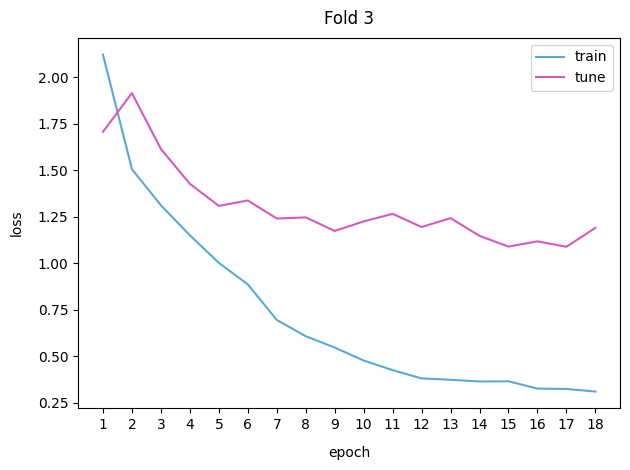

In [24]:
import matplotlib.pyplot as plt

for fold in range(nfolds):
    with open(f'/kaggle/working/logs/log_{fname}_{fold}.json') as f:
        d = json.load(f)
        epoch = []
        train_loss = []
        tune_loss = []
        kappa = []
        for sd in d:
            print(sd)
            epoch.append(sd['epoch'])
            train_loss.append(sd['train_loss'])
            tune_loss.append(sd['tune_loss'])
            kappa.append(sd['kappa'])

    

    plt.figure(dpi=100)
    plt.plot(train_loss, label='train', color="#59A9D4")
    plt.plot(tune_loss, label='tune', color="#D459C1")

    plt.title(f'Fold {fold}', pad=10)
    plt.xlabel('epoch', labelpad=10)
    plt.ylabel('loss', labelpad=10)
    plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))  # Assuming epochs start at 1
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'log_{fname}_{fold}.png')
    plt.show()